# Machine Learning modeling - World Food Program Disaster Relief -

*@XavierTorres*

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
import math

In [2]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error, r2_score
from warnings import simplefilter

In [3]:
df = pd.read_csv(r'Data_input/OUTPUT_WBI_exposer_cyclones_v3.csv', sep=";")

## Data pre-processing

In [4]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'BASIN', 'SUB BASIN', 'NATURE',
       'ISO_TIME', 'COORDS', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'TOTAL_AFFECTED', 'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_

In [5]:
# Arranging columns

df = df[[
    # cols from cyclones
    'SID', 'NAME', 'ISO', 'YEAR',  'ISO_TIME', 'COORDS','BASIN', 'SUB BASIN', 'NATURE',
       'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', '64KN_ASSETS', '96KN_ASSETS', 'CPI',
       'TOTAL_DAMAGE_(000$)', 'TOTAL_DEATHS',

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 
    
    # Target 
    'TOTAL_AFFECTED']]

In [6]:
df.head(3)

,SID,NAME,ISO,YEAR,ISO_TIME,COORDS,BASIN,SUB BASIN,NATURE,TOTAL_HRS,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
0,1949163N07145,DELLA,JPN,1949,"['1949-06-21 03:00:00', '1949-06-22 03:00:00',...","[[35.67, 130.99], [38.35, 135.07], [38.82, 136...",WP,WP,TS,0,...,67.666098,NaN,258.911917,2.867878,36.728,Low,1.187145e+07,3.193122e+06,5.339257e+05,194046
1,1950241N23140,JANE,JPN,1950,"['1950-09-02 18:00:00', '1950-09-03 12:00:00',...","[[31.71, 134.12], [38.48, 137.98], [46.7, 152.8]]",WP,WP,ET,6,...,67.666098,NaN,258.911917,2.867878,36.728,Low,2.845835e+07,1.061136e+07,2.985054e+06,642117
2,1951224N12316,CHARLIE,JAM,1951,"['1951-08-17 21:00:00', '1951-08-18 12:00:00']","[[17.34, -75.41], [18.3, -79.4]]",NAm,CS,TS,15,...,64.770000,NaN,152.453647,2.578304,66.231,Low,1.689243e+06,1.599244e+06,6.550875e+05,20200


- **BASIN and SUBBASIN**: 'MM' value means missing, and **USA_SSHS** column with value -5 = Unknown [XX]:

In [7]:
df["SUB BASIN"]= df["SUB BASIN"].replace('MM', np.nan) 
df["BASIN"]= df["BASIN"].replace('MM', np.nan) 
df["USA_SSHS"]= df["USA_SSHS"].replace(-5, np.nan) 

- As damage in '000 USD is time-money sensitive, we can use the CPI for that data point to calculate **"Total Damage Adjusted"** 
by dividing Total Damage by the CPI. We then drop columns for Damage and CPI.
CPI meaning = https://en.wikipedia.org/wiki/Consumer_price_index

In [8]:
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)"] / df["CPI"]
df["TOTAL_DAMAGE_(000$)_Adjusted"]= df["TOTAL_DAMAGE_(000$)_Adjusted"].replace(0, np.nan)

In [9]:
df = df.drop(["TOTAL_DAMAGE_(000$)",'CPI'], axis=1)
df["TOTAL_DAMAGE_(000$)_Adjusted"].isna().sum()

319

- Trying to create a calculated column that better represents de relative dimension **of exposed assets**. We have several columns for assets exposed depending of windspeed for 34kn+, 64kn+ and 96kn+. Let's add these columns to create a new column:

In [10]:
df['CALC_assets_emdat'] = df['34KN_ASSETS'] + df['64KN_ASSETS'] + df['96KN_ASSETS']
df = df.drop(['64KN_ASSETS', '96KN_ASSETS','96KN_ASSETS'], axis=1)

 - Extracting **month of cyclone**

In [11]:
df['MONTH'] = df.ISO_TIME.apply(lambda x: x[7:9]).astype(int)

- **Transform 'Income_Level'** categories to ordered integers

In [12]:
#Arnab code
unique_list = df['Income_level_Final'].unique()
incomelevel_to_int = dict(zip(unique_list, [1,2,4,3])) # so we assign['Low' =1, 'Low_Middle' =2, 'High'=4, 'High_Middle'=3]
df['Income_level_Final'] = df['Income_level_Final'].apply(lambda inc_level: incomelevel_to_int[inc_level])

- **Arranging columns**

In [13]:
df.shape

(1005, 40)

In [14]:
df.columns

Index(['SID', 'NAME', 'ISO', 'YEAR', 'ISO_TIME', 'COORDS', 'BASIN',
       'SUB BASIN', 'NATURE', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', '34KN_ASSETS', 'TOTAL_DEATHS',
       'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', '

In [15]:
#taking out from model=    'SID', 'NAME', 'ISO', 'YEAR', 'COORDS', 'ISO_TIME',
# Arranging columns

df = df[[
    # cols from cyclones
    'BASIN', 'SUB BASIN', 'NATURE', 
    'MONTH','TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'TOTAL_DEATHS',
    

    # cols from World Bank Indicators:           
    'Air transport, freight (million ton-km)', 'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
    'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
    'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
    'Life expectancy at birth, total (years)', 'Mobile cellular subscriptions (per 100 people)',
    'Population density (people per sq. km of land area)', 'Adjusted savings: education expenditure (% of GNI)',
    'Rural population (% of total population)', 'Income_level_Final',
    
    
    # cols from climada:   
    'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
    
    # Target 
    'TOTAL_AFFECTED']]

- **Check SKEWENESS and apply log**

In [16]:
#determine index for continous variables
num_feats = df.dtypes[df.dtypes != 'object'].index

#Calculate skew and sort
skew_feats = df[num_feats].skew().sort_values(ascending = False)
skewness = pd.DataFrame({'Skew': skew_feats})

In [17]:
skewness

,Skew
TOTAL_DEATHS,28.579526
TOTAL_DAMAGE_(000$)_Adjusted,12.376678
Population density (people per sq. km of land area),10.706739
TOTAL_AFFECTED,7.345349
Arable land (hectares per person),5.368166
pop_max_50_adj,4.378202
pop_max_64_adj,4.182981
pop_max_34_adj,3.211909
CALC_assets_emdat,2.863852
"Air transport, freight (million ton-km)",2.689838


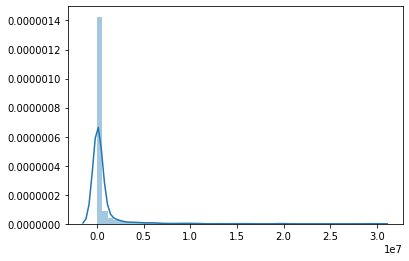

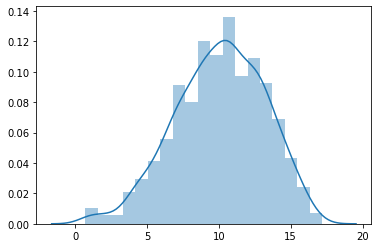

<Figure size 432x288 with 0 Axes>

In [18]:
# Checking distribution for one feature---reusing code from Juber
ax=sns.distplot(df['TOTAL_AFFECTED'].values)

plt.show()
plt.clf()

log_affected=np.log(df['TOTAL_AFFECTED'].values)
ax=sns.distplot(log_affected)

plt.show()
plt.clf()

In [19]:
# Creating list of features to transform, for skew values above 2

feats_to_log = skewness[skewness['Skew'] > 2].index

In [20]:
feats_to_log

Index(['TOTAL_DEATHS', 'TOTAL_DAMAGE_(000$)_Adjusted',
       'Population density (people per sq. km of land area)', 'TOTAL_AFFECTED',
       'Arable land (hectares per person)', 'pop_max_50_adj', 'pop_max_64_adj',
       'pop_max_34_adj', 'CALC_assets_emdat',
       'Air transport, freight (million ton-km)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Net flows from UN agencies US$'],
      dtype='object')

In [21]:
# as log cannot be perfomed to negative numbers, a common technique for handling negative values is to 
# add a constant value to the data prior to applying the log transform. The transformation is 
#therefore log(Y+a) where a is the constant. Some people like to choose a so that min(Y+a) is a very small 
#positive number (like 0.001). Others choose a so that min(Y+a) = 1. For the latter choice, you can show 
# that a = b – min(Y), where b is either a small number or is 1.
# Source : https://blogs.sas.com/content/iml/2011/04/27/log-transformations-how-to-handle-negative-data-values.html

for item in feats_to_log:
    df[item]=np.log((df[item] + 1 - df[item].min()).values)
    

In [22]:
df[feats_to_log].describe()

,TOTAL_DEATHS,TOTAL_DAMAGE_(000$)_Adjusted,Population density (people per sq. km of land area),TOTAL_AFFECTED,Arable land (hectares per person),pop_max_50_adj,pop_max_64_adj,pop_max_34_adj,CALC_assets_emdat,"Air transport, freight (million ton-km)",Adjusted savings: education expenditure (% of GNI),Net flows from UN agencies US$
count,871.000000,6.860000e+02,1005.000000,1005.000000,1004.000000,924.000000,924.000000,924.000000,772.000000,846.000000,9.950000e+02,1005.000000
mean,2.961128,7.047831e+00,4.802937,10.060044,0.147133,14.393414,12.191008,15.831547,25.044701,6.133112,1.215787e+00,15.346366
std,1.726929,2.520944e+00,1.346844,3.132108,0.191261,3.667445,4.914337,2.261811,4.192633,2.641295,4.159006e-01,2.551198
min,0.000000,-1.110223e-16,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.110223e-16,0.000000
25%,1.791759,5.581061e+00,3.899990,8.006034,0.056596,13.624619,11.963555,14.918767,23.592710,4.685979,8.333956e-01,13.909365
50%,2.833213,7.167872e+00,4.968404,10.308919,0.086233,15.165961,13.678987,16.201129,25.635920,6.116558,1.182070e+00,16.307062
75%,4.068990,8.767416e+00,5.707794,12.421414,0.174451,16.532475,15.090018,17.301655,27.460185,8.350740,1.554262e+00,17.263910
max,11.837658,1.430800e+01,9.927154,17.204028,1.403384,19.580564,18.291297,19.744707,30.327386,10.668637,2.672155e+00,19.029468


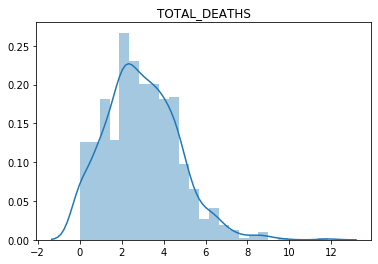

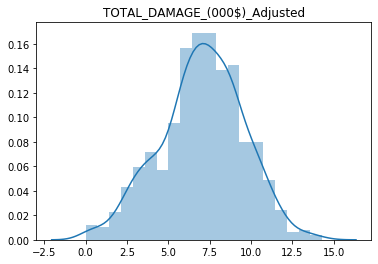

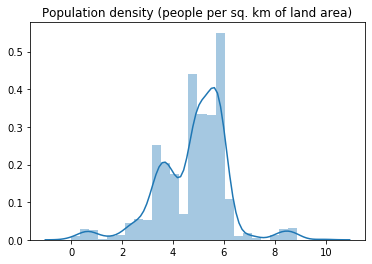

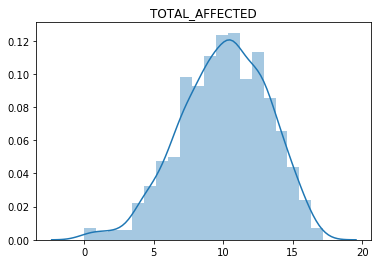

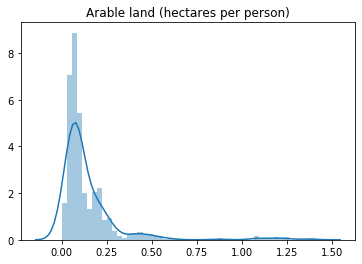

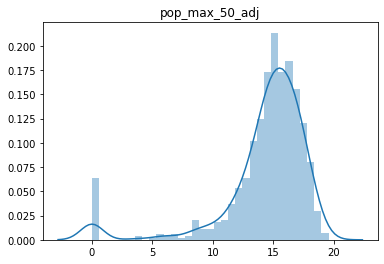

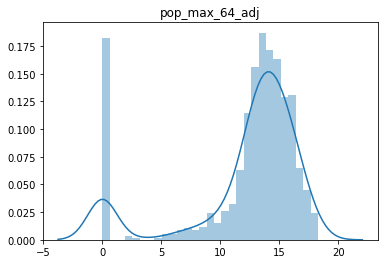

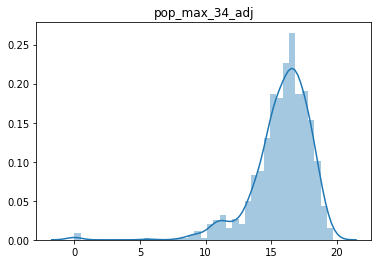

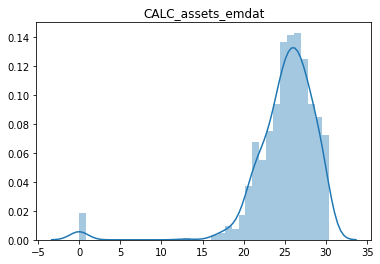

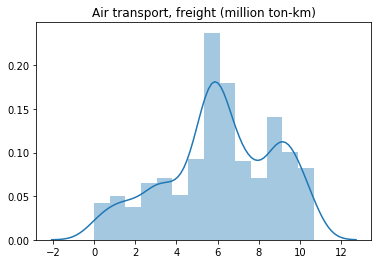

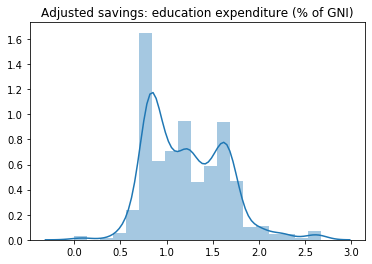

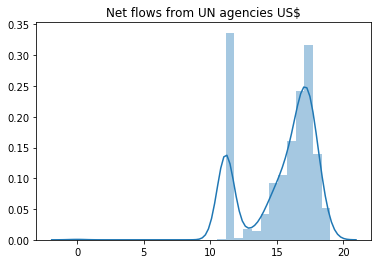

<Figure size 432x288 with 0 Axes>

In [23]:
for item in feats_to_log:
    ax=sns.distplot(df[item].values)
    ax.set_title(item);
    plt.show()
    plt.clf()


In [24]:
df.describe()

,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
count,1005.000000,1005.000000,1005.000000,1005.000000,998.000000,1001.000000,1005.000000,1005.000000,1005.000000,1005.000000,...,1001.000000,996.000000,1005.000000,9.950000e+02,1005.000000,1005.000000,924.000000,924.000000,924.000000,1005.000000
mean,7.780100,13.187065,2.121393,11.065672,0.416834,59.718462,975.450806,12.047601,215.481903,90.011543,...,70.647402,43.296536,4.802937,1.215787e+00,47.065884,2.503483,15.831547,14.393414,12.191008,10.060044
std,2.762945,7.412493,3.811702,8.259346,1.694465,25.080155,56.845274,6.586180,96.090666,31.633313,...,7.252531,47.524739,1.346844,4.159006e-01,22.016753,0.962048,2.261811,3.667445,4.914337,3.132108
min,1.000000,0.000000,0.000000,-1.000000,-4.000000,18.620690,0.000000,1.565217,2.000000,30.000000,...,41.762000,0.000000,0.000000,-1.110223e-16,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,6.000000,0.000000,3.000000,-1.000000,40.000000,966.400000,7.666667,153.800000,62.400000,...,67.136150,0.052346,3.899990,8.333956e-01,23.959000,2.000000,14.918767,13.624619,11.963555,8.006034
50%,8.000000,15.000000,0.000000,9.000000,0.000000,55.250000,981.857143,10.666667,260.750000,89.200000,...,71.063000,27.669708,4.968404,1.182070e+00,53.525000,2.000000,16.201129,15.165961,13.678987,10.308919
75%,10.000000,21.000000,3.000000,21.000000,1.000000,75.705882,993.571429,14.411765,288.250000,114.700000,...,75.164000,83.671391,5.707794,1.554262e+00,64.917000,3.000000,17.301655,16.532475,15.090018,12.421414
max,12.000000,23.000000,12.000000,23.000000,5.000000,150.000000,1013.000000,49.800000,358.000000,171.800000,...,84.680488,328.790446,9.927154,2.672155e+00,92.421000,4.000000,19.744707,19.580564,18.291297,17.204028


- **Apply min_max_scaler**

In [25]:
#df.dropna(inplace = True)

In [26]:
df.shape

(1005, 33)

In [27]:
# first we split df into categorical and numerical features, to merge later
df_cat = df.select_dtypes(include='object')
df_num = df.select_dtypes(exclude='object')


In [28]:
min_max_scaler = preprocessing.MinMaxScaler()

In [29]:
cols_num = df_num.columns #we'll use this later
cols_num

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED'],
      dtype='object')

In [30]:
# x_cols = [x for x in df.columns if x != 'TOTAL_AFFECTED']

In [31]:
X = df_num.values
x_scaled = min_max_scaler.fit_transform(X)
df_num = pd.DataFrame(x_scaled)

In [32]:
df_num.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.454545,0.000000,0.000000,0.041667,0.444444,0.156133,0.987496,0.361457,0.251248,0.492384,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.825013,0.764866,0.720999,0.707732
1,0.727273,0.260870,0.000000,0.291667,0.333333,0.439790,0.962323,0.444384,0.100187,0.492384,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.869294,0.826199,0.815094,0.777290
2,0.636364,0.652174,0.000000,0.666667,0.555556,0.531890,0.961994,0.288895,0.790730,0.722144,...,0.536086,NaN,0.505854,0.416019,0.716623,0.000000,0.726260,0.729552,0.732180,0.576225
3,1.000000,0.652174,0.000000,0.666667,0.666667,0.501354,0.966978,0.029746,0.448447,0.629055,...,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.778650,0.758961,0.726430,0.639506
4,0.545455,0.130435,0.166667,0.083333,0.555556,0.497029,0.968016,0.191455,0.812921,0.569048,...,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.782419,0.755896,0.777679,0.268831


In [33]:
df_num.rename(columns = dict(zip(df_num.columns, cols_num)), inplace = True)

In [34]:
df_num.head(5)

,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,STORM_SPD_MEAN,STORM_DR_MEAN,V_LAND_KN,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
0,0.454545,0.000000,0.000000,0.041667,0.444444,0.156133,0.987496,0.361457,0.251248,0.492384,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.825013,0.764866,0.720999,0.707732
1,0.727273,0.260870,0.000000,0.291667,0.333333,0.439790,0.962323,0.444384,0.100187,0.492384,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.869294,0.826199,0.815094,0.777290
2,0.636364,0.652174,0.000000,0.666667,0.555556,0.531890,0.961994,0.288895,0.790730,0.722144,...,0.536086,NaN,0.505854,0.416019,0.716623,0.000000,0.726260,0.729552,0.732180,0.576225
3,1.000000,0.652174,0.000000,0.666667,0.666667,0.501354,0.966978,0.029746,0.448447,0.629055,...,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.778650,0.758961,0.726430,0.639506
4,0.545455,0.130435,0.166667,0.083333,0.555556,0.497029,0.968016,0.191455,0.812921,0.569048,...,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.782419,0.755896,0.777679,0.268831


In [35]:
df_num.shape

(1005, 30)

In [36]:
df_cat.shape

(1005, 3)

Merging again df_num and df_cat

In [37]:
df_scaled = pd.merge(df_cat, df_num, how='inner', left_index=True, right_index=True)

In [38]:
df_scaled.head(20)

,BASIN,SUB BASIN,NATURE,MONTH,TOTAL_HRS,DAY_HRS,NIGHT_HRS,USA_SSHS,WIND_CALC_MEAN,PRES_CALC_MEAN,...,"Life expectancy at birth, total (years)",Mobile cellular subscriptions (per 100 people),Population density (people per sq. km of land area),Adjusted savings: education expenditure (% of GNI),Rural population (% of total population),Income_level_Final,pop_max_34_adj,pop_max_50_adj,pop_max_64_adj,TOTAL_AFFECTED
0,WP,WP,TS,0.454545,0.000000,0.000000,0.041667,0.444444,0.156133,0.987496,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.825013,0.764866,0.720999,0.707732
1,WP,WP,ET,0.727273,0.260870,0.000000,0.291667,0.333333,0.439790,0.962323,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.869294,0.826199,0.815094,0.777290
2,NAm,CS,TS,0.636364,0.652174,0.000000,0.666667,0.555556,0.531890,0.961994,...,0.536086,NaN,0.505854,0.416019,0.716623,0.000000,0.726260,0.729552,0.732180,0.576225
3,WP,WP,TS,1.000000,0.652174,0.000000,0.666667,0.666667,0.501354,0.966978,...,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.778650,0.758961,0.726430,0.639506
4,WP,WP,TS,0.545455,0.130435,0.166667,0.083333,0.555556,0.497029,0.968016,...,0.450692,NaN,0.453594,0.437484,0.754190,0.333333,0.782419,0.755896,0.777679,0.268831
5,NAm,CS,TS,0.818182,0.260870,0.000000,0.291667,0.777778,0.657480,0.964133,...,0.000000,NaN,0.499393,0.208475,0.913288,0.333333,0.746761,0.683147,0.684128,0.722459
6,NAm,GM,TS,0.727273,0.000000,0.000000,0.041667,0.777778,0.545482,0.955860,...,0.356839,NaN,0.297966,0.464991,0.532855,0.000000,0.748291,0.691140,0.723904,0.543134
7,WP,WP,TS,0.727273,0.913043,0.000000,0.916667,0.333333,0.494593,0.963886,...,0.587152,NaN,0.809984,0.351794,0.160137,1.000000,0.890123,0.811656,0.817883,0.273220
8,WP,WP,TS,0.727273,0.913043,0.000000,0.916667,0.333333,0.571132,0.944097,...,0.603565,NaN,0.559420,0.450075,0.397399,0.000000,0.871527,0.787444,0.750124,0.826607
9,WP,WP,TS,0.454545,0.260870,0.500000,0.041667,0.555556,0.446387,0.964243,...,0.587152,0.0,0.809984,0.351794,0.160137,1.000000,0.907357,0.860952,0.878292,0.559414


In [39]:
df_scaled.shape

(1005, 33)

- **One hot encoding for categorical variables**

In [40]:
obj_feats = df_scaled.dtypes[df_scaled.dtypes == 'object'].index
obj_feats

Index(['BASIN', 'SUB BASIN', 'NATURE'], dtype='object')

In [41]:
feats_to_dummy = obj_feats #selecting feats to make one-hot encoding

for feature in feats_to_dummy:
    dummy = pd.get_dummies(df_scaled[feature], prefix=feature)
    df_scaled = pd.concat([df_scaled,dummy], axis=1)

In [42]:
# Dropping dummed features
df_scaled = df_scaled.drop(feats_to_dummy, axis=1)

In [43]:
df_scaled.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'S

In [44]:
df_scaled.shape

(1005, 54)

In [45]:
df_scaled.columns

Index(['MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
       'TOTAL_DEATHS', 'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj', 'TOTAL_AFFECTED',
       'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'S

In [46]:
#column arrangement 
df_scaled = df_scaled[[
    
     # here columns from cyclones dataset:
    'TOTAL_DEATHS',
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
    
        'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
    'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS',

         
    # here columns from World Bank Indicators dataset:
     'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
         
    # Target   
       'TOTAL_AFFECTED']]

In [47]:
df_scaled.shape

(1005, 53)

### Feature selection

In [48]:
# choosing the features to include in the model
# We take out 'TOTAL_DEATHS' because this input will not be available at the time of prediction
features1 = [   
     # here columns from cyclones dataset:
    'MONTH', 'TOTAL_HRS', 'DAY_HRS', 'NIGHT_HRS', 'USA_SSHS',
       'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN', 'STORM_DR_MEAN',
       'V_LAND_KN', 'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat',
    
        'BASIN_EP', 'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       #'NATURE_DS', 
    'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS',

         
    # here columns from World Bank Indicators dataset:
     'Air transport, freight (million ton-km)',
       'Arable land (hectares per person)', 'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Mobile cellular subscriptions (per 100 people)',
       'Population density (people per sq. km of land area)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Rural population (% of total population)', 'Income_level_Final',
         
    #  here columns from climada:
       'pop_max_34_adj', 'pop_max_50_adj', 'pop_max_64_adj',
         ]

In [49]:
# features2 

features2 = ['MONTH',
       'TOTAL_HRS', 'DAY_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN',
       'STORM_SPD_MEAN', 'STORM_DR_MEAN', 'V_LAND_KN',
       'TOTAL_DAMAGE_(000$)_Adjusted', 'CALC_assets_emdat', 'BASIN_EP',
       'BASIN_NAm', 'BASIN_NI', 'BASIN_SI', 'BASIN_SP', 'BASIN_WP',
       'SUB BASIN_AS', 'SUB BASIN_BB', 'SUB BASIN_CP', 'SUB BASIN_CS',
       'SUB BASIN_EA', 'SUB BASIN_EP', 'SUB BASIN_GM', 'SUB BASIN_NAm',
       'SUB BASIN_SI', 'SUB BASIN_SP', 'SUB BASIN_WA', 'SUB BASIN_WP',
       'NATURE_DS', 'NATURE_ET', 'NATURE_MX', 'NATURE_NR', 'NATURE_SS',
       'NATURE_TS', 'Arable land (hectares per person)',
       'Cereal yield (kg per hectare)',
       'Food production index (2004-2006 = 100)', 'GDP growth (annual %)',
       'GDP per capita (constant 2010 US$)', 'Net flows from UN agencies US$',
       'Life expectancy at birth, total (years)',
       'Adjusted savings: education expenditure (% of GNI)',
       'Income_level_Final',
       'pop_max_64_adj']


In [50]:
# arnab feats

features3 = ['TOTAL_HRS', 'USA_SSHS', 'WIND_CALC_MEAN', 'PRES_CALC_MEAN', 'STORM_SPD_MEAN',
             'V_LAND_KN', 'Population density (people per sq. km of land area)',
             'Rural population (% of total population)', 'Income_level_Final', 'pop_max_34_adj', 
             'pop_max_50_adj', 'pop_max_64_adj']

In [51]:
df_scaled = df_scaled[df_scaled['TOTAL_AFFECTED'] >0]

In [52]:
#some checks....
df_scaled['BASIN_NAm'].unique()

array([0, 1], dtype=uint64)

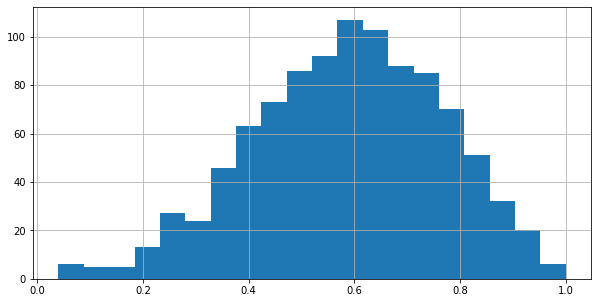

In [53]:
#some checks....
df_scaled['TOTAL_AFFECTED'].hist(bins=20, figsize=(10,5)) #this is logarithmic and scaled(0,1)

__________________

________________________

## Random forest model____________________________________

In [54]:
# df_scaled.dropna(inplace = True)

In [55]:
X = df_scaled[features1].fillna(df_scaled.mean()) #features
# X = df_scaled[features3].fillna(df.mean())
y = df_scaled['TOTAL_AFFECTED']

In [56]:
X.shape

(1002, 51)

In [57]:
# X.to_csv(r'Data_output/X.csv', index = False, sep = ';')

In [58]:
def RF_model(X_train, X_test, y_train, y_test):
    
    estimator_RF = RandomForestRegressor(n_estimators=1000)
    estimator_RF.fit(X_train,y_train)
    print(f"R-squared for train set: {estimator_RF.score(X, y):.2f}")
    print("--------------------------------------------")
    y_pred = estimator_RF.predict(X_test)
    print("------Feature importances---------------------")
    print(estimator_RF.feature_importances_)
    print("--------------------------------------------")
    score_estimator = estimator_RF.score(X_test, y_test)
    print("R-squared for test set =", score_estimator)
    mse = mean_squared_error(y_test,y_pred)
    print("RF estimator mean_squared_error = ", mse)
    rmse = math.sqrt(mse)
    print("RF estimator root_mean_squared_error = ", rmse)
    cvs = cross_val_score(estimator_RF, X, y).mean()
    print("cross_val_score R-squared mean = ", cvs)
    
    
    ##################### Plotting results #########################
    df_y = pd.DataFrame(y_test)
    
    # Visualising the Random Forest Regression results 
    df_y['Pred_Total_Affected'] = y_pred
    df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
    df_y.reset_index(inplace=True, drop=True) #Resetting index
    
    # plt for the Random Forest Regression results ++
    plt.figure(figsize=(12,8))
    plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
    plt.plot(df_y.index, df_y['Pred_Total_Affected'], label = 'Predicted')
    plt.xlabel('Observations')
    plt.ylabel('Num_Affected')
    plt.title('Num Affected - Test Vs Predictions')
    # show a legend on the plot
    plt.legend()
    # Display a figure.
    plt.show()
      
    return

R-squared for train set: 0.77
--------------------------------------------
------Feature importances---------------------
[1.30638311e-02 8.01167991e-03 8.17444928e-03 9.58768058e-03
 5.73949467e-03 1.96508657e-02 3.00991587e-02 3.32696300e-02
 2.18501357e-02 2.35366803e-02 1.91007282e-01 9.48989498e-02
 2.44714310e-04 1.00302580e-03 4.30042385e-04 4.12665786e-04
 4.60418438e-04 1.72867936e-03 1.12128395e-04 7.70219483e-04
 6.34844867e-06 9.62380288e-04 5.22700115e-05 2.13225755e-04
 4.80390449e-04 2.75781273e-04 2.67243346e-04 2.64221484e-04
 4.97274038e-04 1.41443761e-03 4.74898908e-04 1.86257008e-04
 5.13214278e-04 8.52710721e-05 1.23049008e-03 2.29699799e-02
 3.75903645e-02 2.15374509e-02 2.87558371e-02 2.50355943e-02
 9.58704348e-02 3.58508909e-02 2.46168163e-02 1.18625897e-02
 2.15769551e-02 1.98956442e-02 7.32895246e-02 5.34085385e-03
 3.29196683e-02 2.70764536e-02 4.48355064e-02]
--------------------------------------------
R-squared for test set = 0.4275394626428327
RF estimat

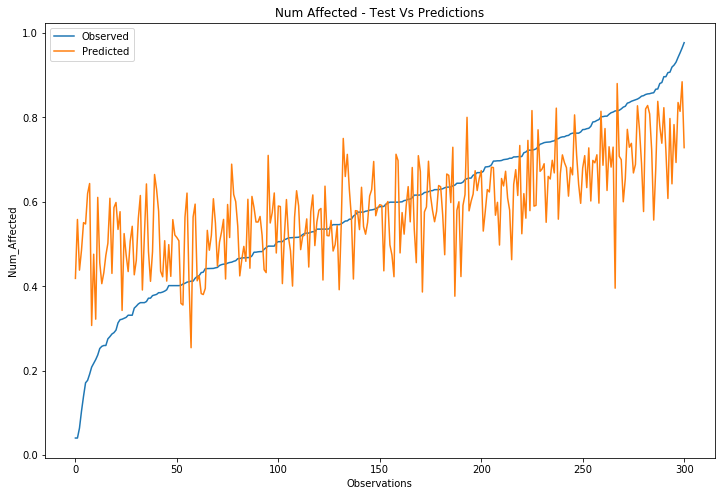

In [59]:
# Applying train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

# calling the function that biulds, fits and shows results
RF_model(X_train, X_test, y_train, y_test)

# PCA______________________

In [60]:
from sklearn.decomposition import PCA

In [61]:
X.shape

(1002, 51)

In [62]:
pca = PCA(n_components=20)
principalComponents = pca.fit_transform(X)
X_pca = pd.DataFrame(data = principalComponents)
             #, columns = ['pc1', 'pc2'])

In [63]:
pca.explained_variance_ratio_.sum()

0.9286027430827823

In [64]:
X_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,-0.692032,0.203579,0.618748,-0.008271,-0.051789,-0.270419,-0.157380,-0.208223,0.211147,0.022748,-0.230097,0.197659,0.338666,-0.129634,0.041377,-0.059069,-0.172124,-0.136262,0.079410,0.245000
1,-0.706721,0.073052,0.405113,0.283903,-0.165948,0.405563,-0.542386,-0.349461,-0.047738,0.236065,-0.128323,0.097258,0.879019,-0.008265,-0.006315,0.087775,-0.196976,0.618554,0.295127,0.012199
2,1.050420,-0.029147,-0.260240,-1.005184,-0.137677,0.008130,-0.225238,-0.048271,-0.100175,0.219375,-0.149999,-0.297909,0.262175,-0.032288,0.188782,-0.198356,-0.184948,0.019928,-0.033703,0.083155
3,-0.674913,0.173810,-0.224078,-0.299547,0.176476,-0.215639,-0.204147,-0.025928,-0.077374,0.216048,0.127095,0.071026,0.313422,0.144112,0.221058,0.141913,0.256197,-0.137574,0.017700,-0.155245
4,-0.657371,0.335268,0.553013,-0.334643,0.066965,-0.294279,-0.090835,-0.084594,0.019635,0.026640,0.210022,-0.088669,0.092996,0.122516,0.227072,0.132147,-0.143153,-0.042725,-0.044151,-0.110454


... let's try the Random Forest model using the PCAs as features

In [65]:
# Applying train/test split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3)

In [66]:
estimator_RF = RandomForestRegressor(n_estimators=1000)
estimator_RF.fit(X_train,y_train)
print(f"R-squared for train set: {estimator_RF.score(X_pca, y):.2f}")
print("--------------------------------------------")
y_pred = estimator_RF.predict(X_test)
print("------Feature importances---------------------")
print(estimator_RF.feature_importances_)
print("--------------------------------------------")
score_estimator = estimator_RF.score(X_test, y_test)
print("R-squared for test set =", score_estimator)
mse = mean_squared_error(y_test,y_pred)
print("RF estimator mean_squared_error = ", mse)
rmse = math.sqrt(mse)
print("RF estimator root_mean_squared_error = ", rmse)
cvs = cross_val_score(estimator_RF, X_pca, y).mean()
print("cross_val_score R-squared mean = ", cvs)

R-squared for train set: 0.71
--------------------------------------------
------Feature importances---------------------
[0.11361984 0.07609839 0.03710068 0.04354669 0.04688049 0.03491741
 0.02664498 0.03181366 0.04112721 0.09788599 0.043422   0.0544637
 0.0710808  0.03959326 0.02830385 0.04675273 0.03994841 0.03142124
 0.04801706 0.0473616 ]
--------------------------------------------
R-squared for test set = 0.16621642168940476
RF estimator mean_squared_error =  0.023811388272642182
RF estimator root_mean_squared_error =  0.15430939139482788
cross_val_score R-squared mean =  0.20599659694202446


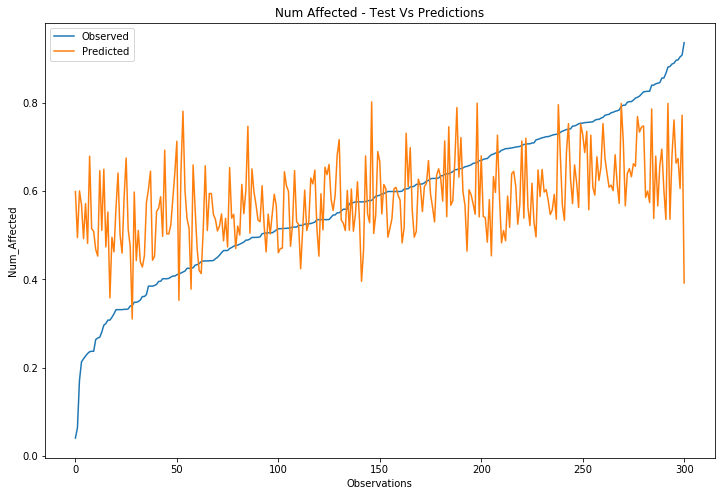

In [67]:
##################### Plotting results #########################

df_y = pd.DataFrame(y_test)
df_y['Pred_Total_Affected'] = y_pred
df_y.sort_values(by = 'TOTAL_AFFECTED',ascending=True, inplace=True) #Sorting the dataset to better visualize results in a plot
df_y.reset_index(inplace=True, drop=True) #Resetting index
    
# plt for the Random Forest Regression results ++
plt.figure(figsize=(12,8))
plt.plot(df_y.index, df_y['TOTAL_AFFECTED'], label = 'Observed')
plt.plot(df_y.index, df_y['Pred_Total_Affected'], label = 'Predicted')
plt.xlabel('Observations')
plt.ylabel('Num_Affected')
plt.title('Num Affected - Test Vs Predictions')
# show a legend on the plot
plt.legend()

# Display  figure
plt.show()

### Hyperparameter tunning with grid search

In [68]:
X = df_scaled[features1].fillna(df_scaled.mean()) #features
# X = df_scaled[features3].fillna(df.mean())
y = df_scaled['TOTAL_AFFECTED']

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) #(X_pca, y, test_size=0.3)

In [70]:
parameters = {'n_estimators':[100, 500, 1000], 
              'max_depth':[5, 10, 20],
              'max_features':[10, 15, 20]              
             }

In [71]:
estimator_RF = GridSearchCV(RandomForestRegressor(), parameters, cv = 3, return_train_score = False)

In [72]:
estimator_RF.fit(X_train,y_train)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                             criterion='mse', max_depth=None,
                                             max_features='auto',
                                             max_leaf_nodes=None,
                                             max_samples=None,
                                             min_impurity_decrease=0.0,
                                             min_impurity_split=None,
                                             min_samples_leaf=1,
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             n_estimators=100, n_jobs=None,
                                             oob_score=False, random_state=None,
                                             verbose=0, warm_start=False),
             iid='deprecated', n_jo

In [73]:
GS_results = pd.DataFrame(estimator_RF.cv_results_)
GS_results.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'param_max_features', 'param_n_estimators', 'params',
       'split0_test_score', 'split1_test_score', 'split2_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score'],
      dtype='object')

In [74]:
cols_needed = ['param_max_depth', 'param_max_features', 'param_n_estimators', 'mean_test_score','rank_test_score']
GS_results = GS_results[cols_needed]
GS_results.sort_values(by=['rank_test_score'], ascending=True)

,param_max_depth,param_max_features,param_n_estimators,mean_test_score,rank_test_score
25,20,20,500,0.403382,1
26,20,20,1000,0.402402,2
17,10,20,1000,0.397492,3
16,10,20,500,0.396875,4
23,20,15,1000,0.396143,5
15,10,20,100,0.394104,6
14,10,15,1000,0.392962,7
22,20,15,500,0.391628,8
24,20,20,100,0.391140,9
13,10,15,500,0.388022,10


___________________________
________________________________